Validation RMSE: 2124797965.3798


/var/folders/j6/pzqtnpsn3jg_xgp4jg2_w4bc0000gn/T/ipykernel_4540/2147629103.py:81: RuntimeWarning: overflow encountered in expm1
  preds_valid_exp = np.expm1(preds_valid)


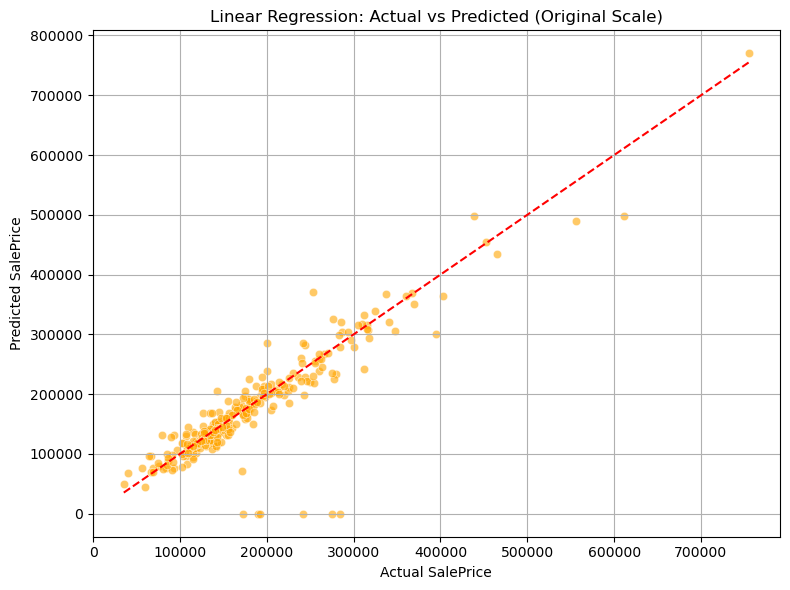

✅ Submission file created successfully.


/var/folders/j6/pzqtnpsn3jg_xgp4jg2_w4bc0000gn/T/ipykernel_4540/2147629103.py:99: RuntimeWarning: overflow encountered in expm1
  preds_test_exp = np.expm1(preds_test)


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1. Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Save test IDs before merging
test_ID = test['Id'].copy()

# Combine train and test for consistent preprocessing
train['TrainFlag'] = 1
test['TrainFlag'] = 0
test['SalePrice'] = np.nan
combined = pd.concat([train, test], axis=0, sort=False)

# 2. Handle Missing Data with domain knowledge
na_as_category_cols = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
    'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType'
]

for col in na_as_category_cols:
    if col in combined.columns:
        combined[col] = combined[col].fillna('None')

# Fill remaining categorical NAs with mode
for col in combined.select_dtypes(include=['object']).columns:
    if col not in na_as_category_cols:
        combined[col] = combined[col].fillna(combined[col].mode()[0])

# Fill numeric NAs with median
for col in combined.select_dtypes(exclude=['object']).columns:
    combined[col] = combined[col].fillna(combined[col].median())

# Treat MSSubClass as categorical
combined['MSSubClass'] = combined['MSSubClass'].astype(str)

# 3. Feature Engineering
combined = pd.get_dummies(combined, drop_first=True)

# 4. Split back into train/test
train_data = combined[combined.TrainFlag == 1].drop(['Id', 'TrainFlag'], axis=1)
test_data = combined[combined.TrainFlag == 0].drop(['Id', 'TrainFlag', 'SalePrice'], axis=1)

X = train_data.drop("SalePrice", axis=1)
y = train_data["SalePrice"]


# Log transform target to reduce skewness
y_log = np.log1p(y)

# 6. Train/Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 7. Model Pipeline (Linear Regression)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Train model
pipe.fit(X_train, y_train)

# Evaluate on validation set
preds_valid = pipe.predict(X_valid)
rmse = mean_squared_error(y_valid, preds_valid, squared=False)
print(f"Validation RMSE: {rmse:.4f}")

# Convert log values back to original scale
y_valid_exp = np.expm1(y_valid)
preds_valid_exp = np.expm1(preds_valid)

#Plotting of Linear Regression
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_valid_exp, y=preds_valid_exp, alpha=0.6, color='orange')
plt.plot([y_valid_exp.min(), y_valid_exp.max()], [y_valid_exp.min(), y_valid_exp.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Linear Regression: Actual vs Predicted (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 9. Final Model Training on full data
pipe.fit(X, y_log)

# 10. Predict on Test Set
preds_test = pipe.predict(test_data)
preds_test_exp = np.expm1(preds_test)

# Handle negative or NaN predictions
preds_test_exp = np.where(preds_test_exp < 0, 0, preds_test_exp)
preds_test_exp = np.nan_to_num(preds_test_exp)

# 11. Create submission
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": preds_test_exp
})

# Sanity check
assert submission.shape[0] == test.shape[0], "Mismatch in test and prediction rows"

submission.to_csv("submission.csv", index=False)
print("✅ Submission file created successfully.")
